# Object localisation project with VGG16 - part 1

In this notebook a model is created that detects objects from varying sizes and flipped objects from an image. Code is applied based on Lazyprogrammer's advanced computer vision course.

## 1. Build the model for Step 1 : Locate actual boxes

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.applications import VGG16
from keras.preprocessing import image

from imageio import imread
from skimage.transform import resize

In [ ]:
# Use VGG16 for transfer learning
vgg = VGG16(input_shape=[100, 100, 3], include_top=False, weights='imagenet')

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# Build the model to identify actual boxes (4 outputs: x1,y1,W,H)
# Sigmoid is used to ensure that the values are within normalized values 0...1
x = Flatten()(vgg.output)
x = Dense(4, activation='sigmoid')(x)
model = Model(vgg.input, x)

In [ ]:
# Define image generator function, that generates black images (value 0) with white boxes (value 1) on them 
def image_generator(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. 
    for _ in range(50):
      X = np.zeros((batch_size, 100, 100, 3))   # black image as a background (value zero)
      Y = np.zeros((batch_size, 4))
      
      for i in range(batch_size):
        # make the boxes and store their location in target
        row0 = np.random.randint(90)
        col0 = np.random.randint(90)
        row1 = np.random.randint(row0, 100)
        col1 = np.random.randint(col0, 100)
        X[i,row0:row1,col0:col1,:] = 1
        Y[i,0] = row0/100.
        Y[i,1] = col0/100.
        Y[i,2] = (row1 - row0)/100.
        Y[i,3] = (col1 - col0)/100.
      
      yield X, Y

In [ ]:
# Compile the model and train it
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001))

In [ ]:
model.fit(
    image_generator(),
    steps_per_epoch=50,
    epochs=5,
)

Epoch 1/5
50/50 [==============================] - 1326s 27s/step - loss: 0.6500
Epoch 2/5
50/50 [==============================] - 1334s 27s/step - loss: 0.5178
Epoch 3/5
50/50 [==============================] - 1324s 26s/step - loss: 0.5085
Epoch 4/5
50/50 [==============================] - 1322s 26s/step - loss: 0.5036
Epoch 5/5
50/50 [==============================] - 1329s 27s/step - loss: 0.5051


In [ ]:
from matplotlib.patches import Rectangle

# Make predictions
def make_prediction():
  # Generate a random image
  x = np.zeros((100, 100, 3))
  row0 = np.random.randint(90)
  col0 = np.random.randint(90)
  row1 = np.random.randint(row0, 100)
  col1 = np.random.randint(col0, 100)
  x[row0:row1,col0:col1,:] = 1
  print(row0, col0, row1, col1)
  
  # Predict
  X = np.expand_dims(x, 0)
  p = model.predict(X)[0]
  
  # Draw the box
  fig, ax = plt.subplots(1)
  ax.imshow(x)
  rect = Rectangle(
      (p[1]*100, p[0]*100),
      p[3]*100, p[2]*100,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

45 40 57 79


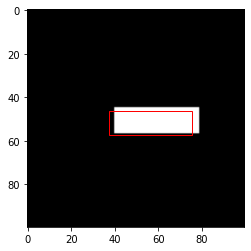

In [ ]:
make_prediction()

## 2. Build the model for Step 2: Locate an actual image

In [ ]:
# Download a pokemon figure and use that for object localisation
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

--2020-12-10 06:41:32--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 104.31.81.48, 172.67.213.166, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2020-12-10 06:41:33 (63.8 MB/s) - ‘charmander-tight.png’ saved [3952/3952]



In [ ]:
!ls

charmander-tight.png  sample_data


In [ ]:
# Let's use imageio library
ch = imread('charmander-tight.png')
# imageio returns array specific to imageio
type(ch)

imageio.core.util.Array

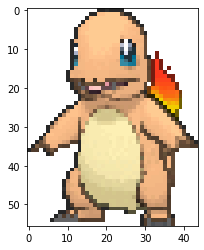

In [ ]:
plt.imshow(ch)

In [ ]:
ch.shape

(56, 44, 4)

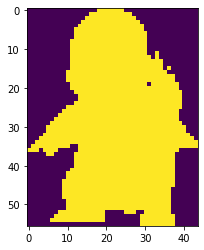

In [ ]:
# 4th channel, transparency, is very useful for this project, since it tells where the image is
# If you plot it, the colors are technically grayscale values, but matplotlib colors them
plt.imshow(ch[:,:,3])
plt.show()

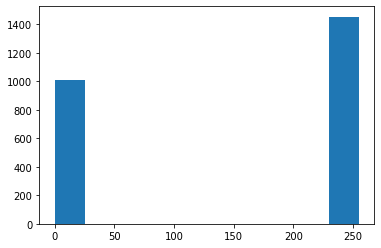

{0, 255}

In [ ]:
# Let's plot the histogram of pixel values in the alpha channel
# There are only two values, 0 and 255
# Where charmander figure is , contains value 255 (white) and rest is 0 (black)
# It’s thus ok, that the rest is black, since then this black is on top of black box
plt.hist(ch[:,:,3].flatten())
plt.show()
set(ch[:,:,3].flatten())

In [ ]:
# Let's create pokemon_generator
# It is the same as image_generator in previous chapter,
# except that instead of white boxes we insert pokemon figure somewhere in the image
POKE_DIM = 200
ch = np.array(ch)
CH_H, CH_W, _ = ch.shape

def pokemon_generator(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 4))
      
      for i in range(batch_size):
        # choose location and store in target
        row0 = np.random.randint(POKE_DIM - CH_H)
        col0 = np.random.randint(POKE_DIM - CH_W)
        row1 = row0 + CH_H
        col1 = col0 + CH_W
        X[i,row0:row1,col0:col1,:] = ch[:,:,:3]
        Y[i,0] = row0/POKE_DIM
        Y[i,1] = col0/POKE_DIM
        
        # later: make the pokemon different sizes
        Y[i,2] = (row1 - row0)/POKE_DIM
        Y[i,3] = (col1 - col0)/POKE_DIM
      
      yield X / 255., Y

In [ ]:
def make_model():
  vgg = VGG16(input_shape=[POKE_DIM, POKE_DIM, 3],include_top=False,weights='imagenet')
  x = Flatten()(vgg.output)
  x = Dense(4, activation='sigmoid')(x)
  model = Model(vgg.input, x)
#   model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9))
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
  return model

In [ ]:
# Create a model instance and train it
model_pokemon = make_model()
model_pokemon.fit(
    pokemon_generator(),
    steps_per_epoch=50,
    epochs=5,
)

Epoch 1/5
50/50 [==============================] - 31s 629ms/step - loss: 0.6259
Epoch 2/5
50/50 [==============================] - 32s 645ms/step - loss: 0.5538
Epoch 3/5
50/50 [==============================] - 32s 636ms/step - loss: 0.5539
Epoch 4/5
50/50 [==============================] - 32s 641ms/step - loss: 0.5547
Epoch 5/5
50/50 [==============================] - 32s 640ms/step - loss: 0.5518


In [ ]:
# Make predictions with the trained model
from matplotlib.patches import Rectangle
def pokemon_prediction():
  # Generate a random image
  x = np.zeros((POKE_DIM, POKE_DIM, 3))
  row0 = np.random.randint(POKE_DIM - CH_H)
  col0 = np.random.randint(POKE_DIM - CH_W)
  row1 = row0 + CH_H
  col1 = col0 + CH_W
  x[row0:row1,col0:col1,:] = ch[:,:,:3]
  print("true:", row0, col0, row1, col1)
  
  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model_pokemon.predict(X)[0]
  
  # Calculate target / loss
  y = np.zeros(4)
  y[0] = row0/POKE_DIM
  y[1] = col0/POKE_DIM
  y[2] = (row1 - row0)/POKE_DIM
  y[3] = (col1 - col0)/POKE_DIM
  
  # Draw the box
  row0 = int(p[0]*POKE_DIM)
  col0 = int(p[1]*POKE_DIM)
  row1 = int(row0 + p[2]*POKE_DIM)
  col1 = int(col0 + p[3]*POKE_DIM)
  print("pred:", row0, col0, row1, col1)
  print("loss:", -np.mean(y * np.log(p) + (1 - y)*np.log(1-p)))
  
  
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*POKE_DIM, p[0]*POKE_DIM),
      p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

true: 56 4 112 48
pred: 57 3 114 47
loss: 0.452792877946049


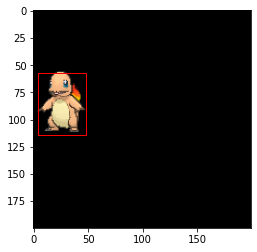

In [ ]:
pokemon_prediction()

## 3. Build the model for Step 3: Locate different sized objects

In [ ]:
#Let's define pokemon generator with resize function
# Note, the pokemon figure is renamed to obj, so that the original is not removed
def pokemon_generator_with_resize(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 4))
      
      for i in range(batch_size):
        # resize charmander - make it bigger or smaller
        scale = 0.5 + np.random.random() # [0.5, 1.5]
        new_height = int(CH_H * scale)
        new_width = int(CH_W * scale)
        obj = resize(
            ch,
            (new_height, new_width),
            preserve_range=True).astype(np.uint8) # keep it from 0..255
        
        # choose location and store in target
        row0 = np.random.randint(POKE_DIM - new_height)
        col0 = np.random.randint(POKE_DIM - new_width)
        row1 = row0 + new_height
        col1 = col0 + new_width
        X[i,row0:row1,col0:col1,:] = obj[:,:,:3]
        Y[i,0] = row0/POKE_DIM
        Y[i,1] = col0/POKE_DIM
        
        # later: make the pokemon different sizes
        Y[i,2] = (row1 - row0)/POKE_DIM
        Y[i,3] = (col1 - col0)/POKE_DIM
      
      yield X/255., Y

In [ ]:
def make_model2():
  vgg = VGG16(
    input_shape=[POKE_DIM, POKE_DIM, 3],
    include_top=False,
    weights='imagenet')
  x = Flatten()(vgg.output)
  x = Dense(4, activation='sigmoid')(x)
  model = Model(vgg.input, x)
#   model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9))
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001))
  return model

In [ ]:
model_poke_resize = make_model2()
model_poke_resize.fit(
    pokemon_generator_with_resize(),
    steps_per_epoch=50,
    epochs=5,
)

Epoch 1/5
50/50 [==============================] - 33s 662ms/step - loss: 0.5617
Epoch 2/5
50/50 [==============================] - 33s 658ms/step - loss: 0.5453
Epoch 3/5
50/50 [==============================] - 33s 656ms/step - loss: 0.5429
Epoch 4/5
50/50 [==============================] - 33s 661ms/step - loss: 0.5450
Epoch 5/5
50/50 [==============================] - 33s 658ms/step - loss: 0.5435


In [ ]:
# Make predictions with resize
def pokemon_prediction_with_resize():
  # resize charmander - make it bigger or smaller
  scale = 0.5 + np.random.random()
  new_height = int(CH_H * scale)
  new_width = int(CH_W * scale)
  obj = resize(
      ch,
      (new_height, new_width),
      preserve_range=True).astype(np.uint8) # keep it from 0..255
  
  # Generate a random image
  x = np.zeros((POKE_DIM, POKE_DIM, 3))
  row0 = np.random.randint(POKE_DIM - new_height)
  col0 = np.random.randint(POKE_DIM - new_width)
  row1 = row0 + new_height
  col1 = col0 + new_width
  x[row0:row1,col0:col1,:] = obj[:,:,:3]
  print("true:", row0, col0, row1, col1)
  
  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model_poke_resize.predict(X)[0]
  
  # Draw the box
  row0 = int(p[0]*POKE_DIM)
  col0 = int(p[1]*POKE_DIM)
  row1 = int(row0 + p[2]*POKE_DIM)
  col1 = int(col0 + p[3]*POKE_DIM)
  print("pred:", row0, col0, row1, col1)
  
  
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*POKE_DIM, p[0]*POKE_DIM),
      p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

true: 154 171 188 198
pred: 155 169 187 193


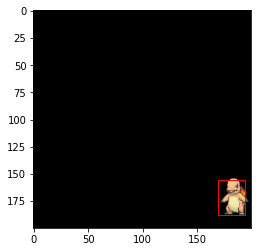

In [ ]:
pokemon_prediction_with_resize()

## 4. Build the model for Step 4: Locate flipped objects

In [ ]:
def pokemon_generator_flip(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 4))
      
      for i in range(batch_size):
        # make the circles and store their location in target
        row0 = np.random.randint(POKE_DIM - CH_H)
        col0 = np.random.randint(POKE_DIM - CH_W)
        row1 = row0 + CH_H
        col1 = col0 + CH_W
        
        # maybe flip
        if np.random.random() < 0.5:
          obj = np.fliplr(ch)
        else:
          obj = ch
        
        X[i,row0:row1,col0:col1,:] = obj[:,:,:3]
        Y[i,0] = row0/POKE_DIM
        Y[i,1] = col0/POKE_DIM
        
        # later: make the pokemon different sizes
        Y[i,2] = (row1 - row0)/POKE_DIM
        Y[i,3] = (col1 - col0)/POKE_DIM
      
      yield X / 255., Y

In [ ]:
model_flip = make_model()
model_flip.fit(
    pokemon_generator_flip(),
    steps_per_epoch=50,
    epochs=5,
)

Epoch 1/5
50/50 [==============================] - 32s 647ms/step - loss: 0.6187
Epoch 2/5
50/50 [==============================] - 32s 644ms/step - loss: 0.5552
Epoch 3/5
50/50 [==============================] - 32s 641ms/step - loss: 0.5542
Epoch 4/5
50/50 [==============================] - 32s 647ms/step - loss: 0.5554
Epoch 5/5
50/50 [==============================] - 32s 642ms/step - loss: 0.5539


In [ ]:
# Make predictions
def pokemon_prediction_flip():
  # Generate a random image
  x = np.zeros((POKE_DIM, POKE_DIM, 3))
  row0 = np.random.randint(POKE_DIM - CH_H)
  col0 = np.random.randint(POKE_DIM - CH_W)
  row1 = row0 + CH_H
  col1 = col0 + CH_W
  
  # maybe flip
  if np.random.random() < 0.5:
    obj = np.fliplr(ch)
  else:
    obj = ch

  x[row0:row1,col0:col1,:] = obj[:,:,:3]
  print("true:", row0, col0, row1, col1)
  
  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model_flip.predict(X)[0]
  
  # Draw the box
  row0 = int(p[0]*POKE_DIM)
  col0 = int(p[1]*POKE_DIM)
  row1 = int(row0 + p[2]*POKE_DIM)
  col1 = int(col0 + p[3]*POKE_DIM)
  print("pred:", row0, col0, row1, col1)
  
  
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*POKE_DIM, p[0]*POKE_DIM),
      p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

true: 97 50 153 94
pred: 96 48 150 90


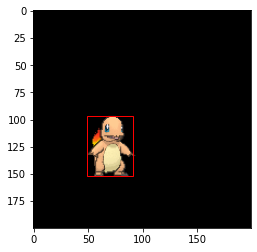

In [ ]:
pokemon_prediction_flip()

## 5. Build the model for Step 5: Locate objects with real backgrounds

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

--2020-12-10 06:52:56--  https://lazyprogrammer.me/course_files/backgrounds.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.31.81.48, 104.31.80.48, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494000 (482K) [application/zip]
Saving to: ‘backgrounds.zip’

backgrounds.zip     100%[===================>] 482.42K   708KB/s    in 0.7s    

2020-12-10 06:52:57 (708 KB/s) - ‘backgrounds.zip’ saved [494000/494000]



In [ ]:
!unzip -n backgrounds.zip

Archive:  backgrounds.zip
   creating: backgrounds/
  inflating: backgrounds/8.jpg       
   creating: __MACOSX/
   creating: __MACOSX/backgrounds/
  inflating: __MACOSX/backgrounds/._8.jpg  
  inflating: backgrounds/9.jpg       
  inflating: __MACOSX/backgrounds/._9.jpg  
  inflating: backgrounds/14.jpg      
  inflating: __MACOSX/backgrounds/._14.jpg  
  inflating: backgrounds/15.jpg      
  inflating: __MACOSX/backgrounds/._15.jpg  
  inflating: backgrounds/12.jpg      
  inflating: __MACOSX/backgrounds/._12.jpg  
  inflating: backgrounds/13.jpg      
  inflating: __MACOSX/backgrounds/._13.jpg  
  inflating: backgrounds/11.jpg      
  inflating: __MACOSX/backgrounds/._11.jpg  
  inflating: backgrounds/10.jpg      
  inflating: __MACOSX/backgrounds/._10.jpg  
  inflating: backgrounds/4.jpg       
  inflating: __MACOSX/backgrounds/._4.jpg  
  inflating: backgrounds/5.jpg       
  inflating: __MACOSX/backgrounds/._5.jpg  
  inflating: backgrounds/7.jpg       
  inflating: __MACOSX/back

In [ ]:
from glob import glob
backgrounds = []

background_files = glob('backgrounds/*.jpg')
for f in background_files:
  # Note: they may not all be the same size
  bg = np.array(image.load_img(f))
  backgrounds.append(bg)

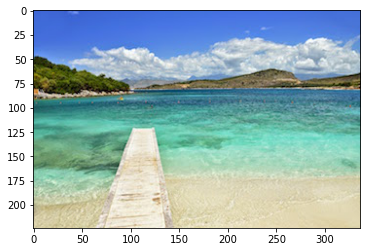

In [ ]:
plt.imshow(backgrounds[3])

In [ ]:
def pokemon_generator_bg(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 4))
      
      for i in range(batch_size):
        # select a random background
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_h = np.random.randint(bg_h - POKE_DIM)
        rnd_w = np.random.randint(bg_w - POKE_DIM)
        X[i] = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()
        
        # resize charmander - make it bigger or smaller
        scale = 0.5 + np.random.random()
        new_height = int(CH_H * scale)
        new_width = int(CH_W * scale)
        obj = resize(
            ch,
            (new_height, new_width),
            preserve_range=True).astype(np.uint8) # keep it from 0..255
        
        # maybe flip
        if np.random.random() < 0.5:
          obj = np.fliplr(obj)
        
        # choose a random location to store the object
        row0 = np.random.randint(POKE_DIM - new_height)
        col0 = np.random.randint(POKE_DIM - new_width)
        row1 = row0 + new_height
        col1 = col0 + new_width
        
        # can't 'just' assign obj to a slice of X
        # since the transparent parts will be black (0)
        mask = (obj[:,:,3] == 0) # find where the pokemon is 0
        bg_slice = X[i,row0:row1,col0:col1,:] # where we want to place `obj`
        bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
        bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
        X[i,row0:row1,col0:col1,:] = bg_slice # put the slice back
        
        # make targets
        Y[i,0] = row0/POKE_DIM
        Y[i,1] = col0/POKE_DIM
        
        # later: make the pokemon different sizes
        Y[i,2] = (row1 - row0)/POKE_DIM
        Y[i,3] = (col1 - col0)/POKE_DIM
      
      yield X / 255., Y

In [ ]:
xx = None
yy = None
for x, y in pokemon_generator_bg():
  xx, yy = x, y
  break

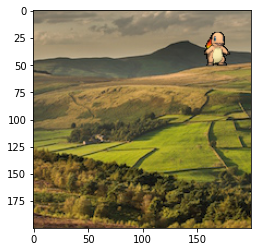

In [ ]:
plt.imshow(xx[5]);

In [ ]:
model_bg = make_model2()
model_bg.fit(
    pokemon_generator_bg(),
    steps_per_epoch=50,
    epochs=5,
)

Epoch 1/5
50/50 [==============================] - 35s 691ms/step - loss: 0.5758
Epoch 2/5
50/50 [==============================] - 34s 681ms/step - loss: 0.5450
Epoch 3/5
50/50 [==============================] - 34s 678ms/step - loss: 0.5398
Epoch 4/5
50/50 [==============================] - 34s 684ms/step - loss: 0.5417
Epoch 5/5
50/50 [==============================] - 34s 681ms/step - loss: 0.5461


In [ ]:
# Make predictions
def pokemon_prediction_bg():
  # select a random background
  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_h = np.random.randint(bg_h - POKE_DIM)
  rnd_w = np.random.randint(bg_w - POKE_DIM)
  x = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()
        
  # resize charmander - make it bigger or smaller
  scale = 0.5 + np.random.random()
  new_height = int(CH_H * scale)
  new_width = int(CH_W * scale)
  obj = resize(
      ch,
      (new_height, new_width),
      preserve_range=True).astype(np.uint8) # keep it from 0..255
        
  # maybe flip
  if np.random.random() < 0.5:
    obj = np.fliplr(obj)
        
  # choose a random location to store the object
  row0 = np.random.randint(POKE_DIM - new_height)
  col0 = np.random.randint(POKE_DIM - new_width)
  row1 = row0 + new_height
  col1 = col0 + new_width
        
  # can't 'just' assign obj to a slice of X
  # since the transparent parts will be black (0)
  mask = (obj[:,:,3] == 0) # find where the pokemon is 0
  bg_slice = x[row0:row1,col0:col1,:] # where we want to place `obj`
  bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
  bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
  x[row0:row1,col0:col1,:] = bg_slice # put the slice back
  print("true:", row0, col0, row1, col1)
  
  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model_bg.predict(X)[0]
  
  # Draw the box
  row0 = int(p[0]*POKE_DIM)
  col0 = int(p[1]*POKE_DIM)
  row1 = int(row0 + p[2]*POKE_DIM)
  col1 = int(col0 + p[3]*POKE_DIM)
  print("pred:", row0, col0, row1, col1)
  
  
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*POKE_DIM, p[0]*POKE_DIM),
      p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

true: 82 11 135 53
pred: 79 7 132 46


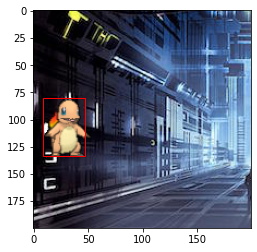

In [ ]:
pokemon_prediction_bg()